# Generate SQL using IBM Granite LLM and execute it on IBM DB2 on cloud.

In this notebook, we are going to use ibm granite model to generate a sql for a given table schema and execute the sql on DB2 on IBM cloud.

Following are the steps that we will follow in the cookbook.

1. #### Setup DB2 on IBM Cloud
2. #### Initialize DB with Tables and populate the tables with data
3. #### Populate the tables with data by executing the following SQL in the DB2 UI
4. #### Get the User id, password and deployment id from the Service credentials of IBM DB2 instance
5. #### Get the DB2 rest end point from IBM DB2 on cloud > dashboard > Administration section
6. #### Install IBM Granite Utils and import lang chain utils.
7. #### Setup IBM Granite LLM from Replicate
8. #### Develop the prompt to generate SQL for a given query and a table structure
9. #### Invoke the granite model with the prompt to get the SQL and apply regex to get the SQL only in case of addition text in generated response
10. #### Get the http connection to IBM DB2 on cloud and get the auth token
11. #### Execute the generated SQL on DB2 on IBM cloud and get the SQL ID of the execution using the sql_jobs api endpoint
12. #### Get the output of the SQL execution using the SQL id thru the sql_jobs api

# Generate SQL using IBM Granite LLM and execute it on IBM DB2 on cloud.

In this notebook, we are going to use ibm granite model to generate a sql for a given table schema and execute the sql on DB2 on IBM cloud.

Following are the steps that we will follow in the cookbook.

1. #### Setup DB2 on IBM Cloud
2. #### Initialize DB with Tables and populate the tables with data
3. #### Populate the tables with data by executing the following SQL in the DB2 UI
4. #### Get the User id, password and deployment id from the Service credentials of IBM DB2 instance
5. #### Get the DB2 rest end point from IBM DB2 on cloud > dashboard > Administration section
6. #### Install IBM Granite Utils and import lang chain utils.
7. #### Setup IBM Granite LLM from Replicate
8. #### Develop the prompt to generate SQL for a given query and a table structure
9. #### Invoke the granite model with the prompt to get the SQL and apply regex to get the SQL only in case of addition text in generated response
10. #### Get the http connection to IBM DB2 on cloud and get the auth token
11. #### Execute the generated SQL on DB2 on IBM cloud and get the SQL ID of the execution using the sql_jobs api endpoint
12. #### Get the output of the SQL execution using the SQL id thru the sql_jobs api

### Pre Requisites
For this we need,
a replicate account that hosts IBM granite models,
an IBM cloud account with IBM DB2 deployed in it.


Once the pre requisites are setup, using this cookbook, we will pass a prompt to granite model and get the response. The response sql is passed on to IBM DB2 through rest api endpoints and executed on IBM DB2 on cloud. The output of the sql is then displayed to the user.

### Setup DB2 on IBM Cloud

Visit https://cloud.ibm.com/docs/Db2onCloud?topic=Db2onCloud-getting-started and setup IBM Db2 on Cloud

### Initialize DB with Tables and populate the tables with data

After setting up IBM DB2 on cloud go to SQL section of the IBM DB2 UI,
execute the following DDL Sql.

CREATE TABLE User (
    user_id INT NOT NULL PRIMARY KEY,
    username VARCHAR(50) NOT NULL,
    email VARCHAR(100) NOT NULL,
    password_hash VARCHAR(100) NOT NULL,
    full_name VARCHAR(100),
    address VARCHAR(255),
    phone_number VARCHAR(20)
);

CREATE TABLE Product (
    product_id INT NOT NULL PRIMARY KEY,
    name VARCHAR(100) NOT NULL,
    description VARCHAR(500),
    price DECIMAL(10, 2) NOT NULL,
    category VARCHAR(50),
    image_url VARCHAR(255),
    available_quantity INT
);

CREATE TABLE Store (
    store_id INT NOT NULL PRIMARY KEY,
    name VARCHAR(100) NOT NULL,
    location VARCHAR(255),
    capacity INT,
    available_capacity INT
);

CREATE TABLE Order (
    order_id INT NOT NULL PRIMARY KEY,
    user_id INT REFERENCES User(user_id),
    order_date TIMESTAMP,
    status VARCHAR(50),
    total_amount DECIMAL(10, 2),
    store_id INT REFERENCES Store(store_id)
);

CREATE TABLE OrderItem (
    order_item_id INT NOT NULL PRIMARY KEY,
    order_id INT REFERENCES Order(order_id),
    product_id INT REFERENCES Product(product_id),
    quantity INT,
    subtotal DECIMAL(10, 2)
);

#### Populate the tables with data by executing the following SQL in the DB2 UI

INSERT INTO User (user_id, username, email, password_hash, full_name, address, phone_number)
VALUES
    (1, 'john_doe', 'john@example.com', 'hashed_password', 'John Doe', '123 Main St', '123-456-7890'),
    (2, 'jane_smith', 'jane@example.com', 'hashed_password', 'Jane Smith', '456 Elm St', '987-654-3210');

INSERT INTO Product (product_id, name, description, price, category, image_url, available_quantity)
VALUES
    (1, 'Toy Car', 'Remote control toy car', 19.99, 'Toys', 'car.jpg', 50),
    (2, 'Action Figure', 'Superhero action figure', 12.99, 'Toys', 'action_figure.jpg', 30),
    (3, 'Laptop', 'High-performance laptop', 899.99, 'Electronics', 'laptop.jpg', 10),
    (4, 'Smartphone', 'Latest smartphone model', 699.99, 'Electronics', 'smartphone.jpg', 15);

INSERT INTO Store (store_id, name, location, capacity, available_capacity)
VALUES
    (1, 'Center A', 'Location A', 100, 80),
    (2, 'Center B', 'Location B', 150, 120);

INSERT INTO Order (order_id, user_id, order_date, status, total_amount, store_id)
VALUES
    (1, 1, '2023-08-01', 'Pending', 32.98, 1),
    (2, 2, '2023-08-02', 'Shipped', 19.99, 2);

INSERT INTO OrderItem (order_item_id, order_id, product_id, quantity, subtotal)
VALUES
    (1, 1, 1, 2, 39.98),
    (2, 1, 2, 1, 12.99),
    (3, 2, 1, 1, 19.99);


### Get the User id, password and deployment id from the Service credentials of IBM DB2 instance
![Screenshot 2024-09-18 at 09.36.50.png](attachment:eab8e045-6dd9-4e79-82c9-ddbfda03b2e2.png)

From the Service credential's db2.authentication key, get the user id and password

db2": {
      "authentication": {
        "method": "direct",
        "password": "maDVHz4oUqmVE_mod",
        "username": "tcq27st"
      },

Also, get the deployment id from,
"instance_administration_api": {
    "deployment_id": "crn:v1:bluemix:public:dashdb-for-transactions:us-south:a/f665a69257a9fbe8b8bf0f77bc176a0",
    "instance_id": "crn:v1:bluemix:public:",
    "root": "https://api.db2.cloud.ibm.com/v5/ibm"
  }

In [ ]:
db_username = "username-from-service-credentials"
db_password = "password-from-service-credentials"

#### Get the DB2 rest end point from IBM DB2 on cloud > dashboard > Administration section
![Screenshot 2024-09-18 at 09.47.14.png](attachment:6db0748d-32a3-4f3b-be6a-2f5c9ed99750.png)

In [ ]:
db2_rest_endpoint = "rest-api-host-name-from-IBM-DB2-Administration-section"
db2_deployment_id = "deployment-id-from-service-credentials"

### Install IBM Granite Utils and import lang chain utils.

In [ ]:
!pip install git+https://github.com/ibm-granite-community/utils

### Setup IBM Granite LLM from Replicate

In [ ]:
from ibm_granite_community.langchain_utils import find_langchain_model

#### Get the replicate API key from Replicate Account settings page
![Screenshot 2024-09-18 at 09.59.36.png](attachment:fc6ebf65-8c1f-462a-a646-fcb28d79af58.png)

In [ ]:
model_id = "ibm-granite/granite-8b-code-instruct-128k"
granite_via_replicate = find_langchain_model(platform="Replicate", model_id=model_id)

user_text = "display the order items of orders that are marked 'Pending'"

### Develop the prompt to generate SQL for a given query and a table structure 

In [ ]:
prompt = f"Write an executable SQL Query to {user_text} using the tables enclosed in ~~\n~~Table: Product\ncolumns: product_id, name, description, price, category, image_url, available_quantity\nTable: Order\nColumns: order_id, user_id, order_date, status, total_amount, store_id\nTable: OrderItem\nColumns: order_item_id, order_id, product_id, quantity, subtotal\n~~.'"
print(f"Prompt to model : {prompt}")

#### Invoke the granite model with the prompt to get the SQL and apply regex to get the SQL only in case of addition text in generated response

In [ ]:
import re
replicate_response = granite_via_replicate.invoke(prompt)
sqlRegex = re.compile('SELECT[\\s\\S]*;')
sqlMatch = sqlRegex.search(replicate_response)
sqlString = sqlMatch.group()
print(f"Granite response from Replicate: {replicate_response}\n")
print("Extracted SQL from LLM response\n")
print(sqlString)


### Get the http connection to IBM DB2 on cloud and get the auth token

In [ ]:
import http.client
import json
conn = http.client.HTTPSConnection(db2_rest_endpoint)

payload = {"userid":db_username,"password":db_password}
headers = {
    'content-type': "application/json",
    'x-deployment-id': db2_deployment_id
    }
has_auth=False
try:
    conn.request("POST", "/dbapi/v4/auth/tokens", json.dumps(payload), headers)
    res = conn.getresponse()
    data = res.read()
    auth_token = data.decode("utf-8")
    auth_resp = json.loads(auth_token)
    # print(auth_resp['token'])
    print("Got Auth Token")
    has_auth=True
except:
  print("An exception occurred") 


### Execute the generated SQL on DB2 on IBM cloud and get the SQL ID of the execution using the sql_jobs api endpoint

In [ ]:

if has_auth:
    payload = {"commands":sqlString,"limit":10,"separator":";","stop_on_error" : "no"}
    headers = {
        'content-type': "application/json",
        'authorization': f"Bearer {auth_resp['token']}",
        'x-deployment-id': db2_deployment_id
        }
    
    conn.request("POST", "/dbapi/v4/sql_jobs", json.dumps(payload), headers)
    
    res = conn.getresponse()
    data = res.read()
    json_data = json.loads(data)
    sql_id = json_data['id']
    print("Executed SQL on DB..\n")
    print(json_data)
    print()
    print(f"SQL ID : {sql_id}")

### Get the output of the SQL execution using the SQL id thru the sql_jobs api

In [ ]:
if has_auth:
    conn.request("GET", f"/dbapi/v4/sql_jobs/{sql_id}", headers=headers)
    res = conn.getresponse()
    data = res.read()
    
    json_data = json.loads(data)
    # print(data.decode("utf-8"))
    print(json_data['results'][0]['columns'])
    for row in json_data['results'][0]['rows']:
        print(row)


### Pre Requisites
For this we need,
a replicate account that hosts IBM granite models,
an IBM cloud account with IBM DB2 deployed in it.


Once the pre requisites are setup, using this cookbook, we will pass a prompt to granite model and get the response. The response sql is passed on to IBM DB2 through rest api endpoints and executed on IBM DB2 on cloud. The output of the sql is then displayed to the user.

### Setup DB2 on IBM Cloud

Visit https://cloud.ibm.com/docs/Db2onCloud?topic=Db2onCloud-getting-started and setup IBM Db2 on Cloud

### Initialize DB with Tables and populate the tables with data

After setting up IBM DB2 on cloud go to SQL section of the IBM DB2 UI,
execute the following DDL Sql.

CREATE TABLE User (
    user_id INT NOT NULL PRIMARY KEY,
    username VARCHAR(50) NOT NULL,
    email VARCHAR(100) NOT NULL,
    password_hash VARCHAR(100) NOT NULL,
    full_name VARCHAR(100),
    address VARCHAR(255),
    phone_number VARCHAR(20)
);

CREATE TABLE Product (
    product_id INT NOT NULL PRIMARY KEY,
    name VARCHAR(100) NOT NULL,
    description VARCHAR(500),
    price DECIMAL(10, 2) NOT NULL,
    category VARCHAR(50),
    image_url VARCHAR(255),
    available_quantity INT
);

CREATE TABLE Store (
    store_id INT NOT NULL PRIMARY KEY,
    name VARCHAR(100) NOT NULL,
    location VARCHAR(255),
    capacity INT,
    available_capacity INT
);

CREATE TABLE Order (
    order_id INT NOT NULL PRIMARY KEY,
    user_id INT REFERENCES User(user_id),
    order_date TIMESTAMP,
    status VARCHAR(50),
    total_amount DECIMAL(10, 2),
    store_id INT REFERENCES Store(store_id)
);

CREATE TABLE OrderItem (
    order_item_id INT NOT NULL PRIMARY KEY,
    order_id INT REFERENCES Order(order_id),
    product_id INT REFERENCES Product(product_id),
    quantity INT,
    subtotal DECIMAL(10, 2)
);

#### Populate the tables with data by executing the following SQL in the DB2 UI

INSERT INTO User (user_id, username, email, password_hash, full_name, address, phone_number)
VALUES
    (1, 'john_doe', 'john@example.com', 'hashed_password', 'John Doe', '123 Main St', '123-456-7890'),
    (2, 'jane_smith', 'jane@example.com', 'hashed_password', 'Jane Smith', '456 Elm St', '987-654-3210');

INSERT INTO Product (product_id, name, description, price, category, image_url, available_quantity)
VALUES
    (1, 'Toy Car', 'Remote control toy car', 19.99, 'Toys', 'car.jpg', 50),
    (2, 'Action Figure', 'Superhero action figure', 12.99, 'Toys', 'action_figure.jpg', 30),
    (3, 'Laptop', 'High-performance laptop', 899.99, 'Electronics', 'laptop.jpg', 10),
    (4, 'Smartphone', 'Latest smartphone model', 699.99, 'Electronics', 'smartphone.jpg', 15);

INSERT INTO Store (store_id, name, location, capacity, available_capacity)
VALUES
    (1, 'Center A', 'Location A', 100, 80),
    (2, 'Center B', 'Location B', 150, 120);

INSERT INTO Order (order_id, user_id, order_date, status, total_amount, store_id)
VALUES
    (1, 1, '2023-08-01', 'Pending', 32.98, 1),
    (2, 2, '2023-08-02', 'Shipped', 19.99, 2);

INSERT INTO OrderItem (order_item_id, order_id, product_id, quantity, subtotal)
VALUES
    (1, 1, 1, 2, 39.98),
    (2, 1, 2, 1, 12.99),
    (3, 2, 1, 1, 19.99);


### Get the User id, password and deployment id from the Service credentials of IBM DB2 instance
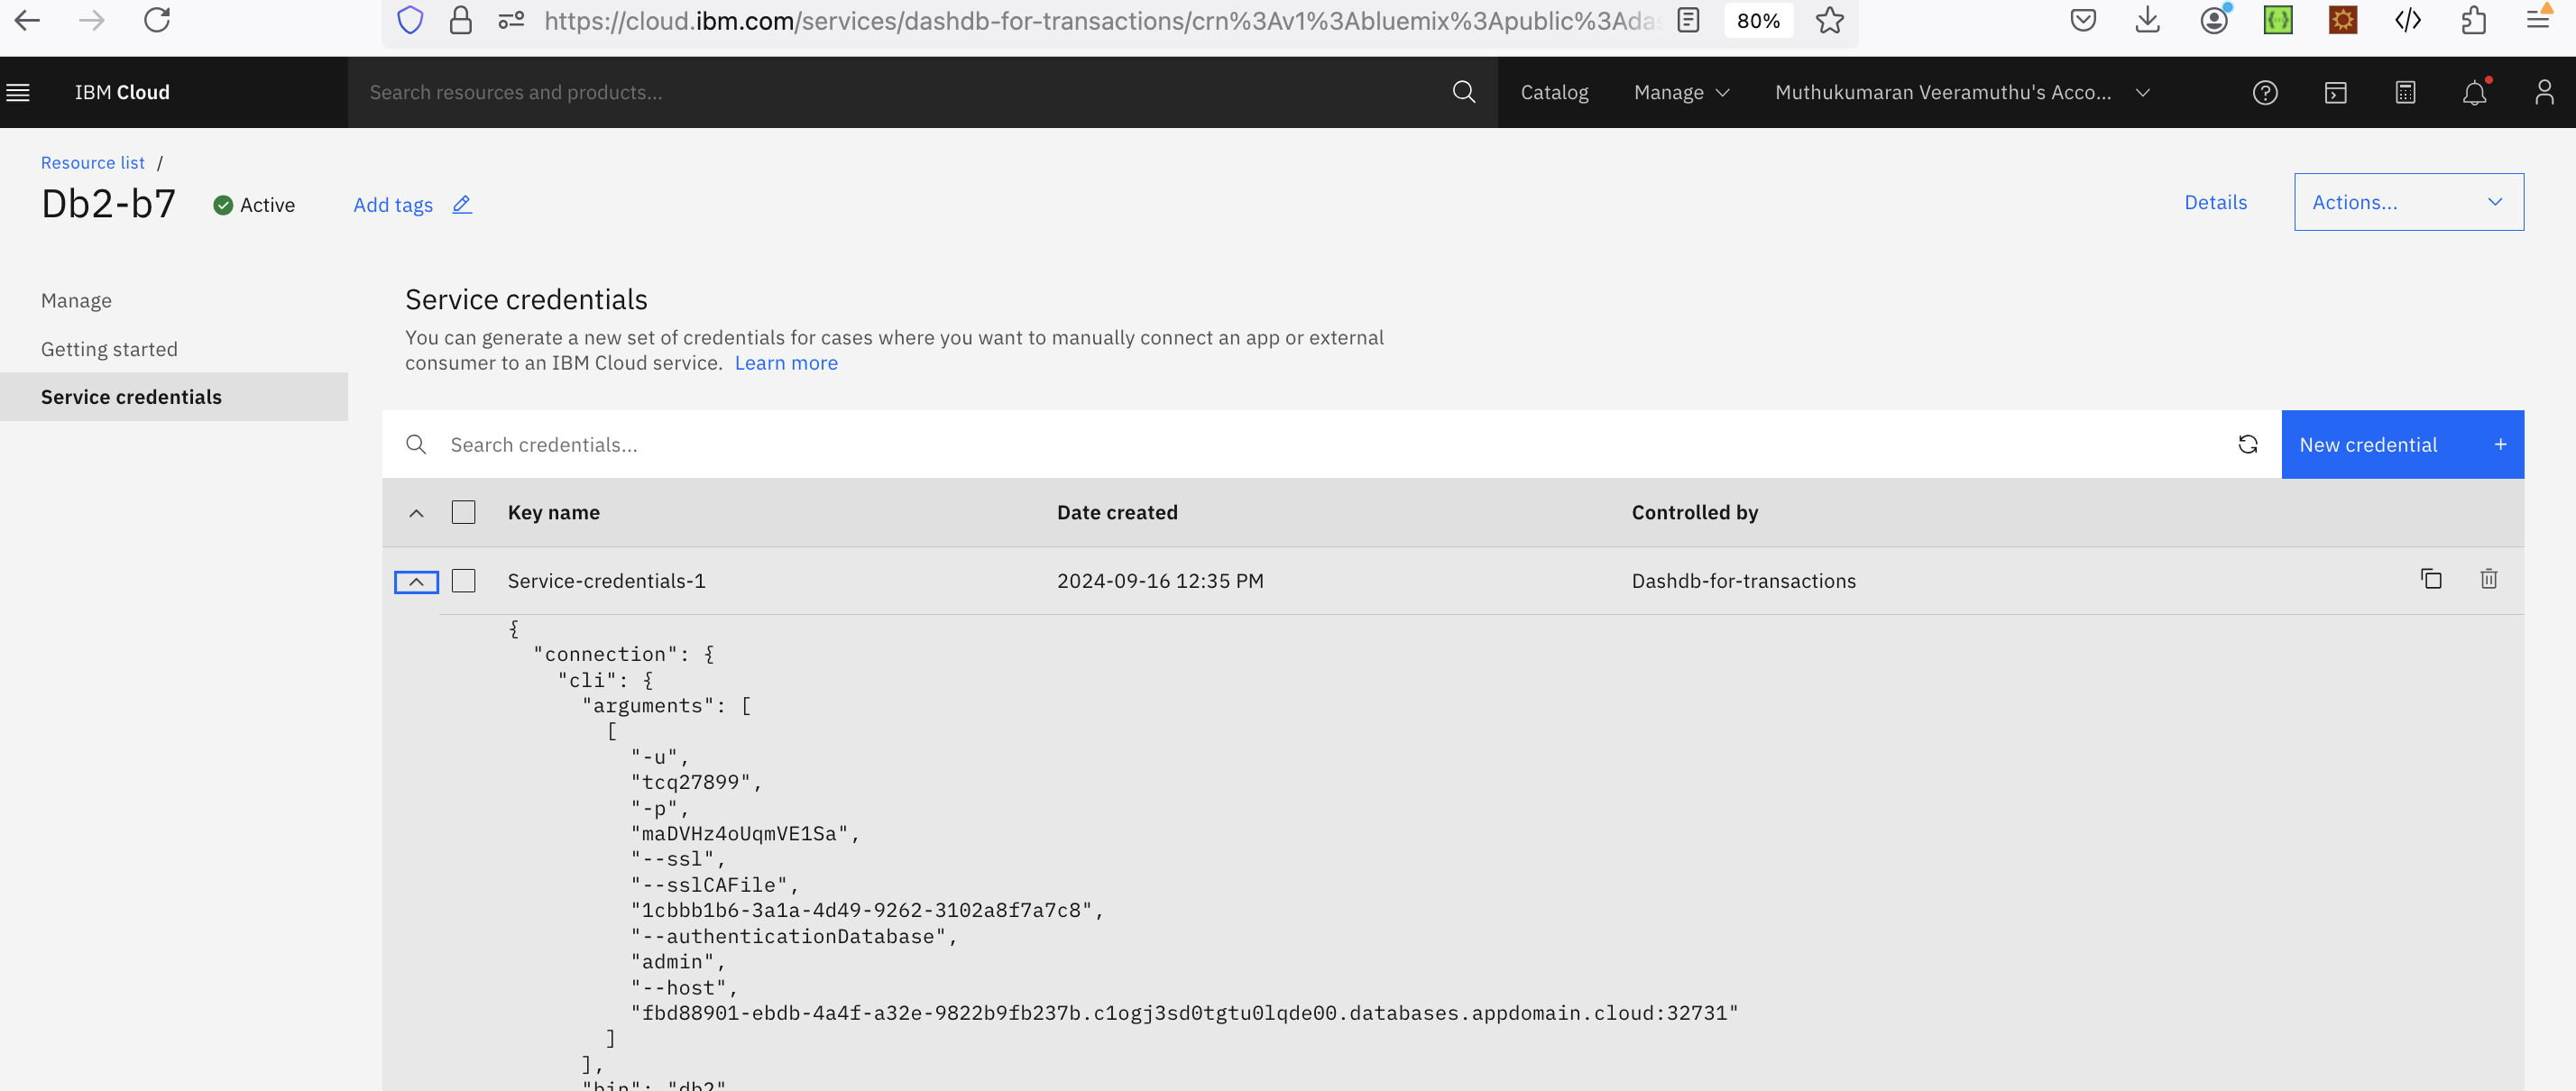

From the Service credential's db2.authentication key, get the user id and password

db2": {
      "authentication": {
        "method": "direct",
        "password": "maDVHz4oUqmVE_mod",
        "username": "tcq27st"
      },

Also, get the deployment id from,
"instance_administration_api": {
    "deployment_id": "crn:v1:bluemix:public:dashdb-for-transactions:us-south:a/f665a69257a9fbe8b8bf0f77bc176a0",
    "instance_id": "crn:v1:bluemix:public:",
    "root": "https://api.db2.cloud.ibm.com/v5/ibm"
  }

In [ ]:
db_username = "username-from-service-credentials"
db_password = "password-from-service-credentials"

#### Get the DB2 rest end point from IBM DB2 on cloud > dashboard > Administration section
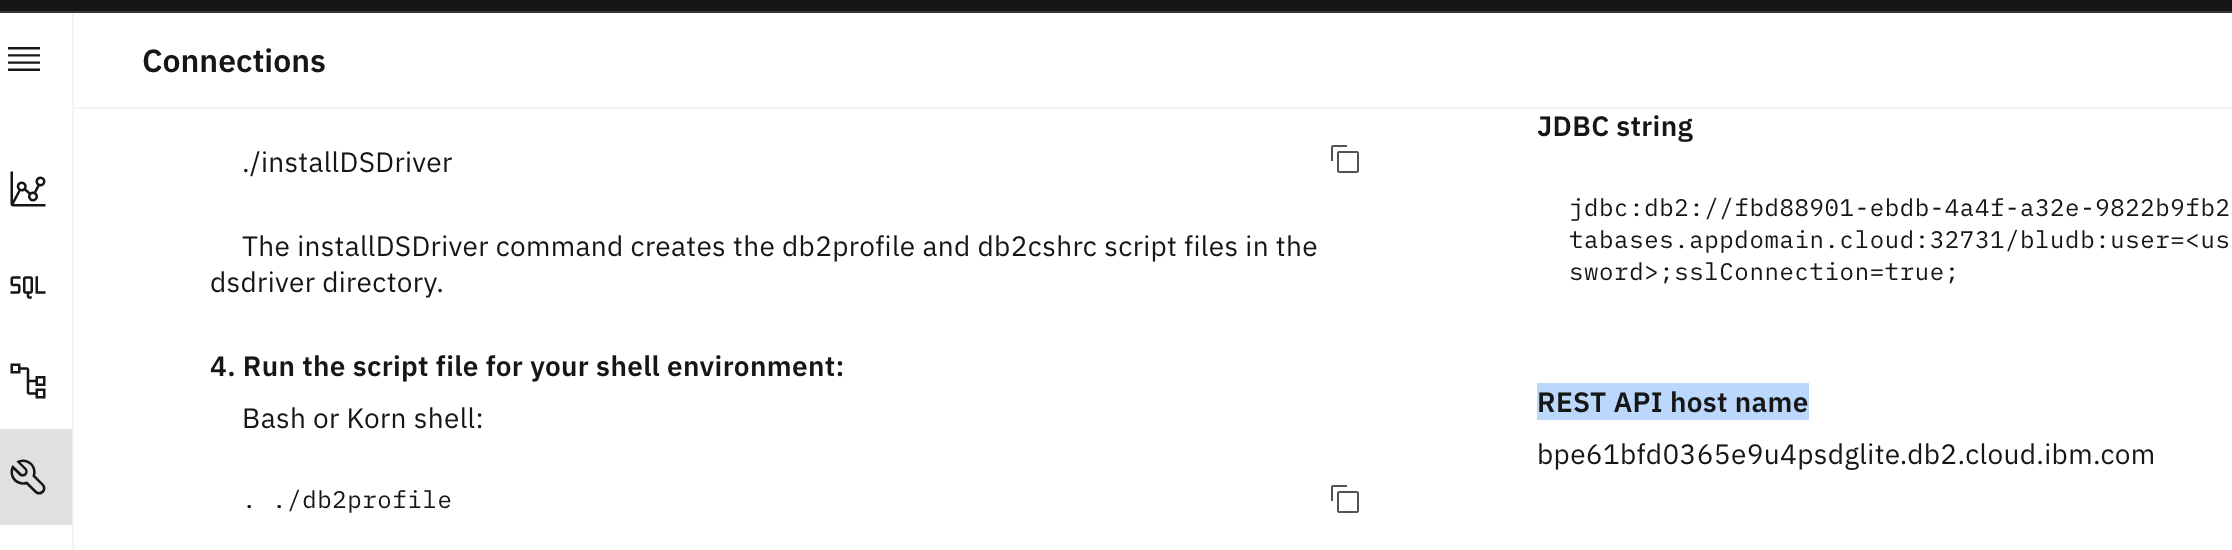

In [ ]:
db2_rest_endpoint = "rest-api-host-name-from-IBM-DB2-Administration-section"
db2_deployment_id = "deployment-id-from-service-credentials"

### Install IBM Granite Utils and import lang chain utils.

In [ ]:
!pip install git+https://github.com/ibm-granite-community/utils

### Setup IBM Granite LLM from Replicate

In [ ]:
from ibm_granite_community.langchain_utils import find_langchain_model

#### Get the replicate API key from Replicate Account settings page
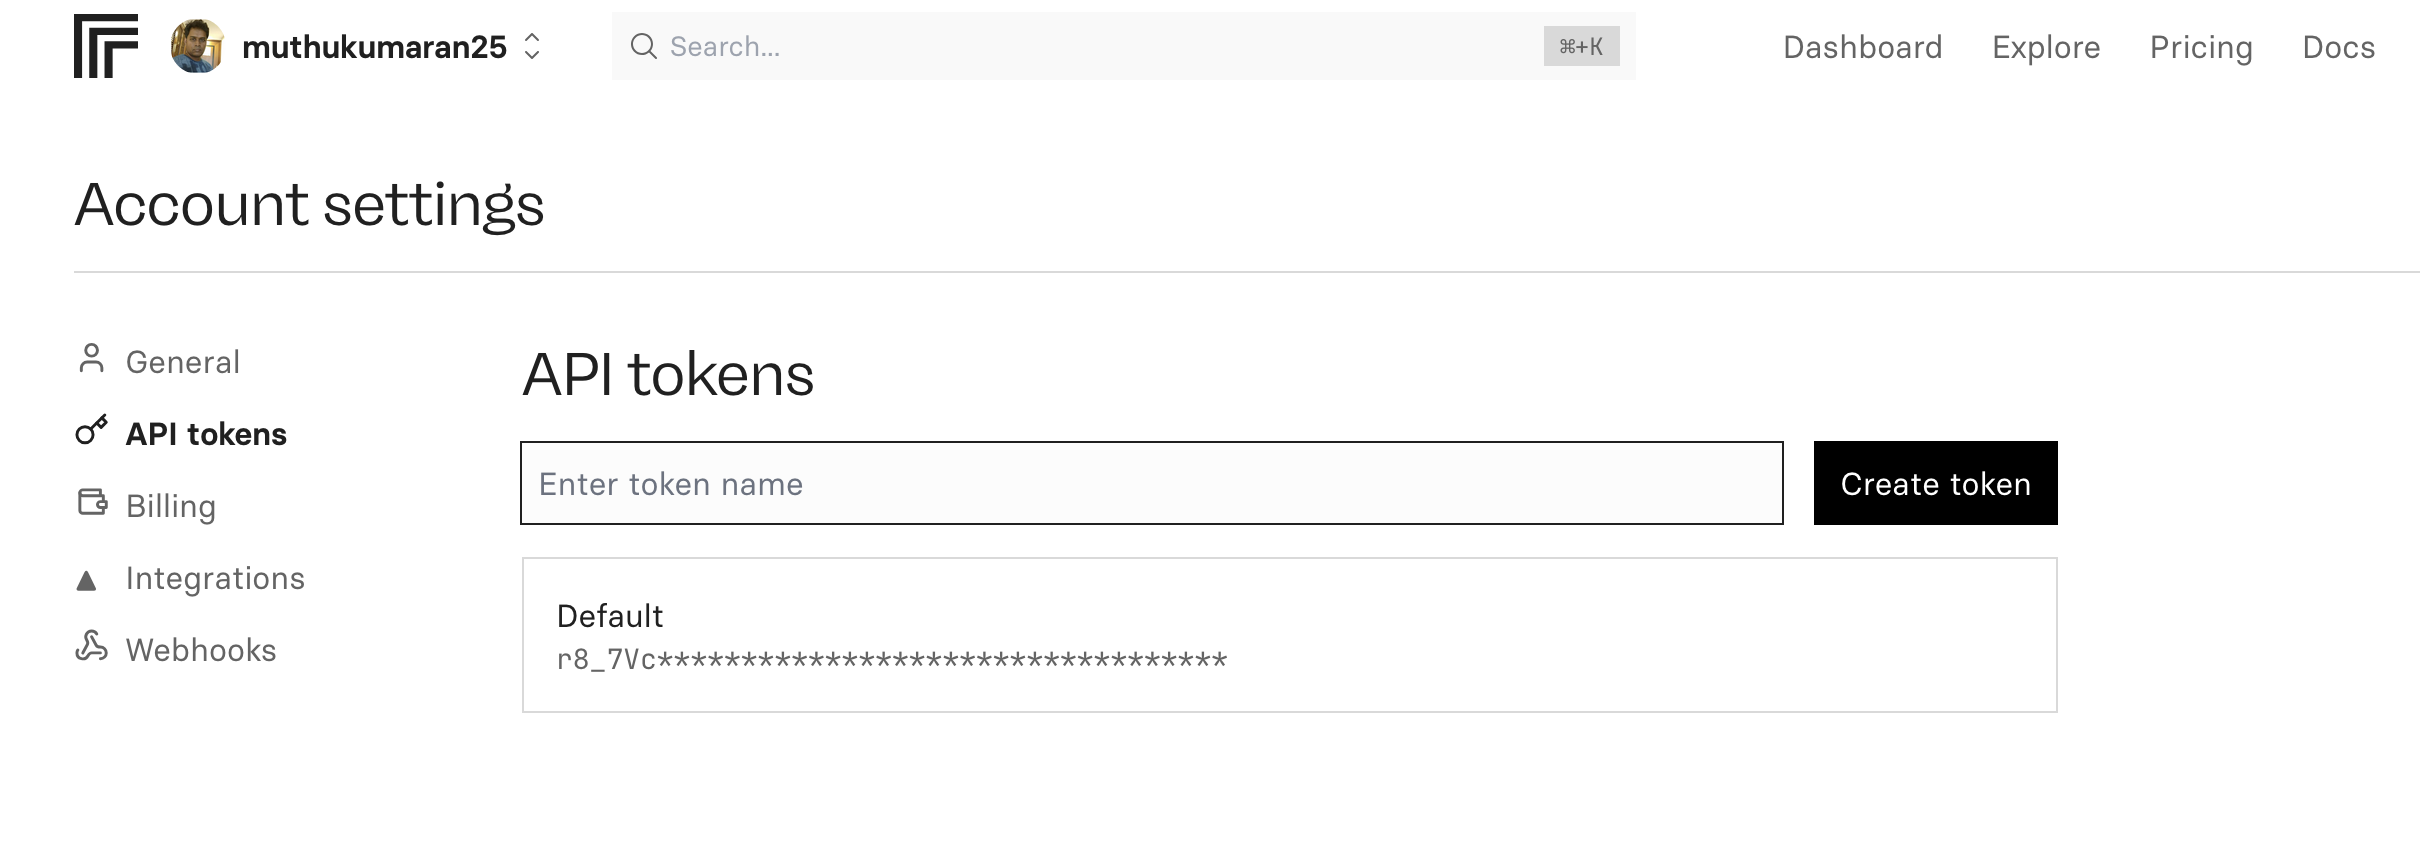

In [ ]:
model_id = "ibm-granite/granite-8b-code-instruct-128k"
granite_via_replicate = find_langchain_model(platform="Replicate", model_id=model_id)

user_text = "display the order items of orders that are marked 'Pending'"

### Develop the prompt to generate SQL for a given query and a table structure 

In [ ]:
prompt = f"Write an executable SQL Query to {user_text} using the tables enclosed in ~~\n~~Table: Product\ncolumns: product_id, name, description, price, category, image_url, available_quantity\nTable: Order\nColumns: order_id, user_id, order_date, status, total_amount, store_id\nTable: OrderItem\nColumns: order_item_id, order_id, product_id, quantity, subtotal\n~~.'"
print(f"Prompt to model : {prompt}")

#### Invoke the granite model with the prompt to get the SQL and apply regex to get the SQL only in case of addition text in generated response

In [ ]:
import re
replicate_response = granite_via_replicate.invoke(prompt)
sqlRegex = re.compile('SELECT[\\s\\S]*;')
sqlMatch = sqlRegex.search(replicate_response)
sqlString = sqlMatch.group()
print(f"Granite response from Replicate: {replicate_response}\n")
print("Extracted SQL from LLM response\n")
print(sqlString)


### Get the http connection to IBM DB2 on cloud and get the auth token

In [ ]:
import http.client
import json
conn = http.client.HTTPSConnection(db2_rest_endpoint)

payload = {"userid":db_username,"password":db_password}
headers = {
    'content-type': "application/json",
    'x-deployment-id': db2_deployment_id
    }

conn.request("POST", "/dbapi/v4/auth/tokens", json.dumps(payload), headers)

res = conn.getresponse()
data = res.read()
auth_token = data.decode("utf-8")
auth_resp = json.loads(auth_token)
# print(auth_resp['token'])
print("Got Auth Token")

### Execute the generated SQL on DB2 on IBM cloud and get the SQL ID of the execution using the sql_jobs api endpoint

In [ ]:
payload = {"commands":sqlString,"limit":10,"separator":";","stop_on_error" : "no"}
headers = {
    'content-type': "application/json",
    'authorization': f"Bearer {auth_resp['token']}",
    'x-deployment-id': db2_deployment_id
    }

conn.request("POST", "/dbapi/v4/sql_jobs", json.dumps(payload), headers)

res = conn.getresponse()
data = res.read()
json_data = json.loads(data)
sql_id = json_data['id']
print("Executed SQL on DB..\n")
print(json_data)
print()
print(f"SQL ID : {sql_id}")

### Get the output of the SQL execution using the SQL id thru the sql_jobs api

In [ ]:
conn.request("GET", f"/dbapi/v4/sql_jobs/{sql_id}", headers=headers)
res = conn.getresponse()
data = res.read()

json_data = json.loads(data)
# print(data.decode("utf-8"))
print(json_data['results'][0]['columns'])
for row in json_data['results'][0]['rows']:
    print(row)
